In [1]:
import glob
from astropy.table import Table
import fitsio
import os
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import numpy as np
from scipy import stats
import pandas as pd

In [37]:
def process_fits_file(fafn):
    tile_data = {}
    _, h = fitsio.read(fafn, "PRIMARY", header=True)
    
    try:
        program = h["FAPRGRM"].lower()
    except KeyError:
        program = "undefined"
        print('failed FAPRGM using undefined', fafn)
        #return None
        
    try:
        date_string = h["NOWTIME"]
    except KeyError:
        print('failed NOW TIME, using FA_RUN', fafn)
        date_string = h["FA_RUN"]
        #return None
    
    tile_data["program"] = program
    tile_data["ra"] = h["TILERA"]
    tile_data["dec"] = h["TILEDEC"]
    
    try:
        datetime_obj = datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S%z').replace(tzinfo=pytz.UTC)
    except:
        datetime_obj = datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S').replace(tzinfo=pytz.UTC)
        
    print(datetime_obj)
    reference_date = datetime(2021, 5, 14, tzinfo=pytz.UTC) # The start of the main survey
    days_difference = (datetime_obj - reference_date).total_seconds()/(24.0*3600.0)
    tile_data["days_difference"] = days_difference
    
    d = Table(fitsio.read(fafn, "FIBERASSIGN"))

    sky = d["OBJTYPE"] == "SKY"
    good_fibers = d["FIBERSTATUS"]==0 
    is_lowp = d["PRIORITY"]<1400
    is_verylowp = d["PRIORITY"]<100
    is_lowp_init = d["PRIORITY_INIT"]<1400
    is_verylowp_init = d["PRIORITY_INIT"]<100
    is_target = d["OBJTYPE"]=="TGT"
    expid_str = fafn.split(os.path.sep)[-2]
    
    try:
        is_secondary = d['SCND_TARGET']!=0
        tile_data["nsecondary"] = np.count_nonzero(is_secondary)
    except:
        is_secondary = [False] * len(d["OBJTYPE"])
        tile_data["nsecondary"] = 0
    
    tile_data["nsky"] = np.count_nonzero(sky)
    tile_data["nskygoodfiber"] = np.count_nonzero(sky & good_fibers)
    tile_data["nskybadfiber"] = np.count_nonzero(sky & (~good_fibers))
    tile_data["expid"] = int(expid_str)
    tile_data["nlowp"] = np.count_nonzero(is_lowp & is_target)
    tile_data["nverylowp"] = np.count_nonzero(is_verylowp & is_target)
    tile_data["nsecondarylowpinit"] = np.count_nonzero(is_lowp_init & is_target & is_secondary)
    tile_data["nsecondaryverylowpinit"] = np.count_nonzero(is_verylowp_init & is_target & is_secondary)

    
    return tile_data

def process_fits_files(fafns):
    tile_nsky = []
    tile_nsky_goodfiber = []
    tile_nsky_badfiber = []
    tile_nlowp = []
    tile_nverylowp = []
    expid = []
    tile_program = []
    tile_ra = []
    tile_dec = []
    tile_days = []
    tile_nsecondary = []
    tile_nsecondary_lowpinit = []
    tile_nsecondary_verylowpinit = []

    

    for fafn in fafns:
        tile_data = process_fits_file(fafn)
        if tile_data:
            tile_program.append(tile_data["program"])
            tile_ra.append(tile_data["ra"])
            tile_dec.append(tile_data["dec"])
            tile_days.append(tile_data["days_difference"])
            tile_nsky.append(tile_data["nsky"])
            tile_nsky_goodfiber.append(tile_data["nskygoodfiber"])
            tile_nsky_badfiber.append(tile_data["nskybadfiber"])
            tile_nlowp.append(tile_data["nlowp"])
            tile_nverylowp.append(tile_data["nverylowp"])
            tile_nsecondary.append(tile_data["nsecondary"])
            tile_nsecondary_lowpinit.append(tile_data["nsecondarylowpinit"])
            tile_nsecondary_verylowpinit.append(tile_data["nsecondaryverylowpinit"])
            expid.append(tile_data["expid"])
            
    data = {"tile_nsky": np.array(tile_nsky),
            "tile_nsky_goodfiber":np.array(tile_nsky_goodfiber),
            "tile_nsky_badfiber":np.array(tile_nsky_badfiber),
            "tile_nlowp":np.array(tile_nlowp),
            "tile_nverylowp":np.array(tile_nverylowp),
            "expid": np.array(expid),
            "tile_program": np.array(tile_program),
            "tile_ra": np.array(tile_ra),
            "tile_dec": np.array(tile_dec),
            "tile_days": np.array(tile_days),
            "tile_nsecondary":np.array(tile_nsecondary),
            "tile_nsecondary_lowpinit":np.array(tile_nsecondary_lowpinit),
            "tile_nsecondary_verylowpinit":np.array(tile_nsecondary_verylowpinit)
           }
    df = pd.DataFrame(data)
    return df

def process_year(year):
    fafns = sorted(glob.glob("/global/cfs/cdirs/desi/spectro/data/{}*/????????/fiberassign*fits.gz".format(year)))
    print('gathered {} files'.format(len(fafns)))
    df_year = process_fits_files(fafns)
    filename = '{}_nsky_lowp_data.csv'.format(year)
    df_year.to_csv(filename, index=False)
    
def process_sim(year):
    string = "/global/cfs/cdirs/desi/users/forero/fba_sim_next_tiles_{}/???/fiberassign*fits.gz".format(year)
    print(string)
    fafns = sorted(glob.glob(string))
    print('gathered {} files'.format(len(fafns)))
    df_year = process_fits_files(fafns)
    filename = '{}_nsky_lowp_data.csv'.format(year)
    df_year.to_csv(filename, index=False)

In [38]:
process_sim(20240415)

/global/cfs/cdirs/desi/users/forero/fba_sim_next_tiles_20240415/???/fiberassign*fits.gz
gathered 218 files
2024-04-16 16:08:46+00:00
2024-04-16 16:09:06+00:00
2024-04-16 16:09:24+00:00
2024-04-16 16:09:41+00:00
2024-04-16 16:10:00+00:00
2024-04-16 16:10:17+00:00
2024-04-16 16:10:34+00:00
2024-04-16 16:10:53+00:00
2024-04-16 16:11:11+00:00
2024-04-16 16:11:28+00:00
2024-04-16 16:11:45+00:00
2024-04-16 16:12:02+00:00
2024-04-16 16:12:19+00:00
2024-04-16 16:12:36+00:00
2024-04-16 16:12:53+00:00
2024-04-16 16:13:11+00:00
2024-04-16 16:13:28+00:00
2024-04-16 16:13:46+00:00
2024-04-16 16:14:04+00:00
2024-04-16 16:14:22+00:00
2024-04-16 16:14:40+00:00
2024-04-16 16:14:58+00:00
2024-04-16 16:15:15+00:00
2024-04-16 16:15:34+00:00
2024-04-16 16:15:52+00:00
2024-04-16 16:16:09+00:00
2024-04-16 16:16:28+00:00
2024-04-16 16:16:45+00:00
2024-04-16 16:17:03+00:00
2024-04-16 16:17:20+00:00
2024-04-16 16:17:38+00:00
2024-04-16 16:17:57+00:00
2024-04-16 16:18:14+00:00
2024-04-16 16:18:30+00:00
2024-04-1

In [18]:
#fafns = sorted(glob.glob("/global/cfs/cdirs/desi/spectro/data/{}*/????????/fiberassign*fits.gz".format(2024)))

In [19]:
#d = Table(fitsio.read(fafns[4], "FIBERASSIGN"))
#is_second = d['SCND_TARGET']!=0
#is_lowp = d['PRIORITY']<100
#is_lowpinit = d['PRIORITY_INIT']<100

In [20]:
#np.count_nonzero(d[is_second&is_lowpinit]['PRIORITY_INIT'])

In [21]:
#set(d['OBJTYPE'][is_second]), set(d['OBJTYPE'][is_lowp])

In [26]:
#for year in [2021, 2022, 2023, 2024]:
#    process_year(year)

In [23]:
data_A = pd.read_csv('2021_nsky_lowp_data.csv')
data_B = pd.read_csv('2022_nsky_lowp_data.csv')
data_C = pd.read_csv('2023_nsky_lowp_data.csv')
data_D = pd.read_csv('2024_nsky_lowp_data.csv')

In [24]:
data = pd.concat([data_A, data_B, data_C, data_D], axis=0, ignore_index=True)

In [39]:
data_sim = pd.read_csv('20240415_nsky_lowp_data.csv')

In [61]:
def plot_quantity(data, col_name='tile_nsky', col_label='number of sky fibers', 
                  xlim=[0,3],ylim=[400,1000], prefix='obs'):
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)

    plt.title('Dark')
    ii = (data['tile_program']=='dark') #& (data['day']>600)
    dark_time = np.array(data['tile_days'][ii]/365.0)
    dark_counts = np.array(data[col_name][ii])
    ll = np.argsort(dark_time)
    dark_time = dark_time[ll]
    dark_counts = dark_counts[ll]
    
    plt.scatter(dark_time, dark_counts, alpha=0.1)

    plt.ylabel(col_label)
    plt.xlabel("Years since survey started")
    plt.ylim(ylim)
    plt.xlim(xlim)


    slope, intercept, r_value, p_value, std_err = stats.linregress(data['tile_days'][ii], data[col_name][ii])
    x = np.sort(data['tile_days'][ii])
    plt.plot(x/365., slope*x + intercept, color='red')
    print(slope)

    plt.subplot(1,3,2)
    plt.title('Bright')
    ii = (data['tile_program']=='bright') #& (data['day']>600)
    bright_time = np.array(data['tile_days'][ii]/365.0)
    bright_counts = np.array(data[col_name][ii])
    ll = np.argsort(bright_time)
    bright_time = bright_time[ll]
    bright_counts = bright_counts[ll]    
    
    plt.scatter(bright_time, bright_counts, alpha=0.1)

    plt.xlabel("Years since survey started")
    plt.ylim(ylim)
    plt.xlim(xlim)

    slope, intercept, r_value, p_value, std_err = stats.linregress(data['tile_days'][ii], data[col_name][ii])
    x = np.sort(data['tile_days'][ii])
    plt.plot(x/365., slope*x + intercept, color='red')
    print(slope)

    
    plt.subplot(1,3,3)
    plt.plot(dark_time, np.cumsum(dark_counts), label='dark')

    plt.plot(bright_time, np.cumsum(bright_counts), label='bright')
    

    plt.xlabel("Years since survey started")
    plt.ylabel("Cumulative "+col_label)
    plt.xlim(xlim)
    plt.legend()
    plt.grid()
    plt.savefig(prefix+col_name+'.jpg')

In [76]:
def plot_quantity_hist(data, col_name='tile_nsky', col_label='number of sky fibers', 
                  xlim=[400,1000], prefix='obs'):
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)

    plt.title('Dark')
    ii = (data['tile_program']=='dark') #& (data['day']>600)
    dark_time = np.array(data['tile_days'][ii]/365.0)
    dark_counts = np.array(data[col_name][ii])
    ll = np.argsort(dark_time)
    dark_time = dark_time[ll]
    dark_counts = dark_counts[ll]
    
    plt.hist(dark_counts)

    plt.ylabel("Histogram")
    plt.xlabel(col_label)
    #plt.xlim(xlim)

    plt.subplot(1,3,2)
    plt.title('Bright')
    ii = (data['tile_program']=='bright') #& (data['day']>600)
    bright_time = np.array(data['tile_days'][ii]/365.0)
    bright_counts = np.array(data[col_name][ii])
    ll = np.argsort(bright_time)
    bright_time = bright_time[ll]
    bright_counts = bright_counts[ll]    
    
    plt.hist(bright_counts)

    plt.xlabel(col_label)
    #plt.xlim(xlim)


    
    plt.subplot(1,3,3)
    plt.plot(np.arange(len(dark_counts)), np.cumsum(dark_counts), label='dark')

    plt.plot(np.arange(len(bright_counts)), np.cumsum(bright_counts), label='bright')
    

    plt.xlabel("Tiles")
    plt.ylabel("Cumulative "+col_label)
    plt.legend()
    plt.grid()
    plt.savefig(prefix+col_name+'.jpg')

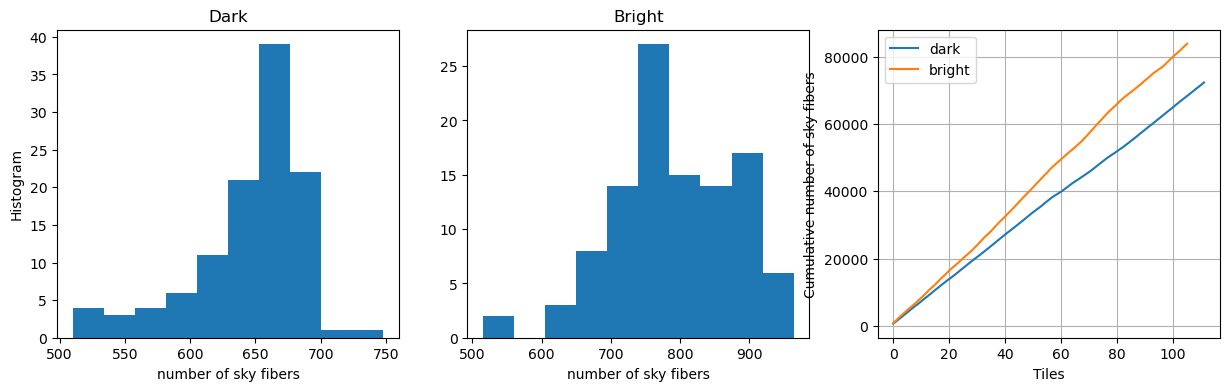

In [82]:
plot_quantity_hist(data_sim, col_name='tile_nsky', col_label='number of sky fibers',prefix='sim')

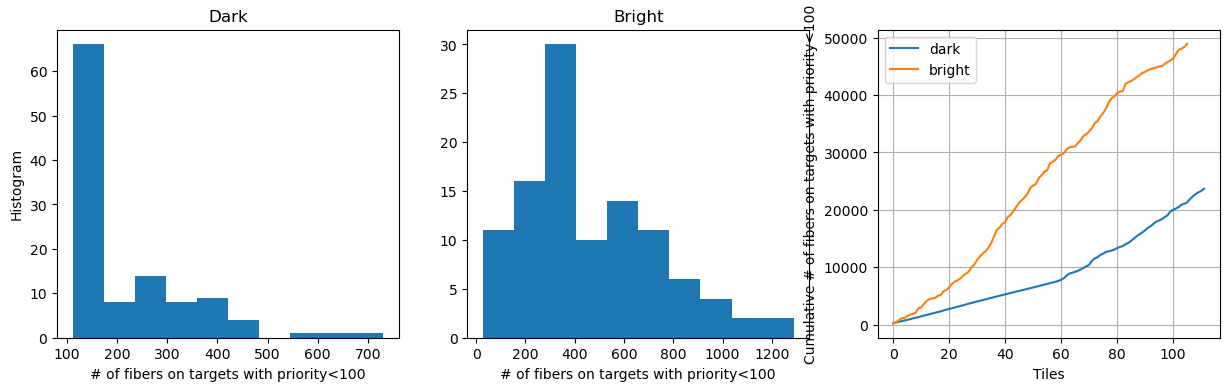

In [83]:
plot_quantity_hist(data_sim, col_name='tile_nverylowp', col_label='# of fibers on targets with priority<100',prefix='sim')

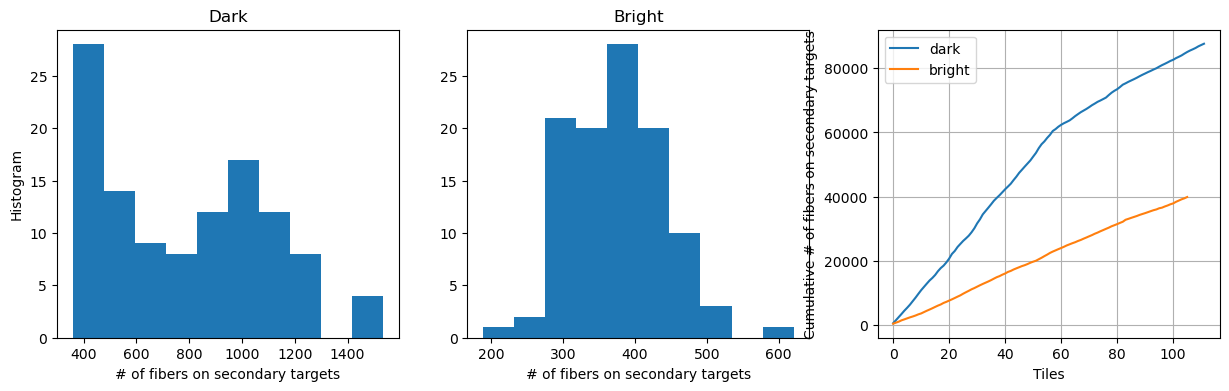

In [84]:
plot_quantity_hist(data_sim, col_name='tile_nsecondary', col_label='# of fibers on secondary targets',prefix='sim')

-722.423197033005
-2580.3988576808338


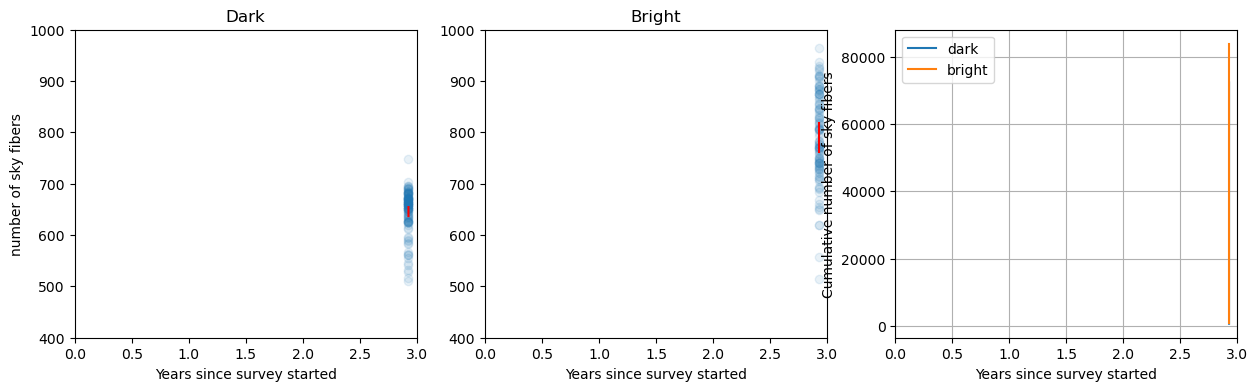

In [81]:
plot_quantity(data_sim, col_name='tile_nsky', col_label='number of sky fibers', prefix='sim')

11792.664211817177
555.5491977178123


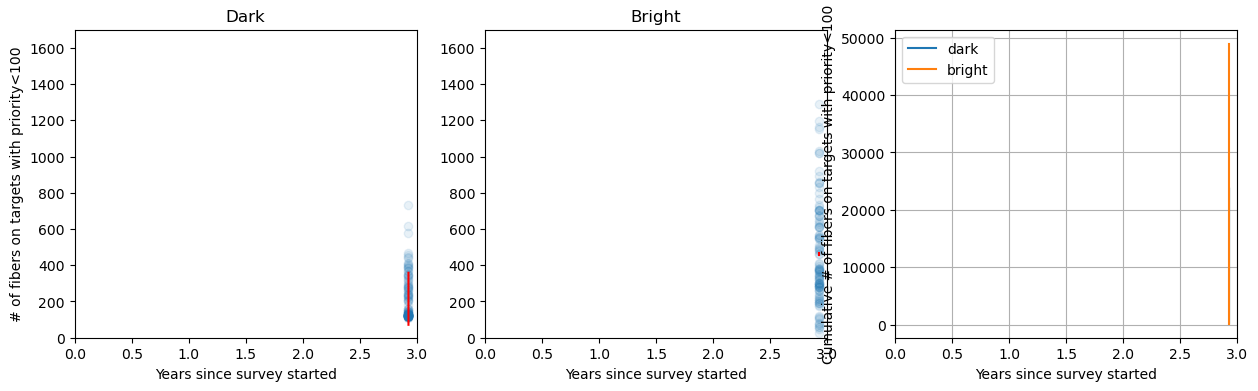

In [42]:
plot_quantity(data_sim, col_name='tile_nverylowp', col_label='# of fibers on targets with priority<100', 
              ylim=[0,1700], prefix='sim')

-33235.14785500113
-2096.8377894202476


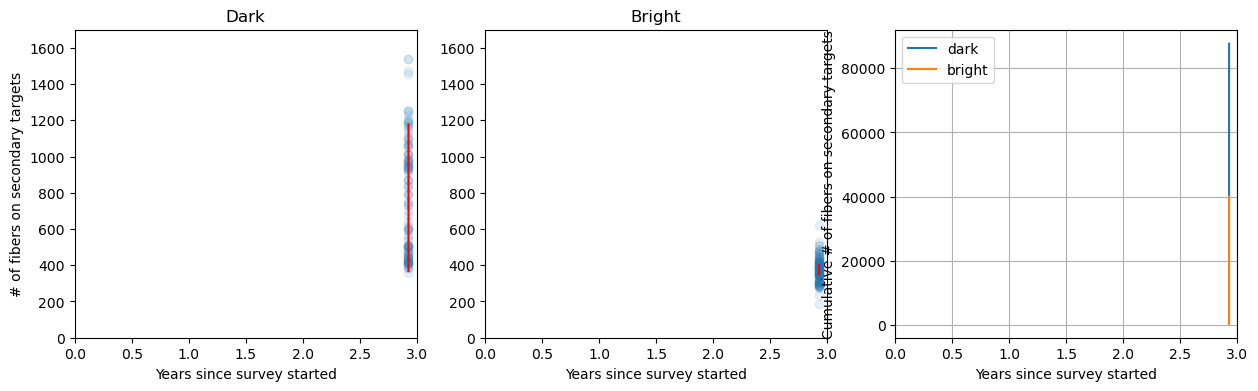

In [43]:
plot_quantity(data_sim, col_name='tile_nsecondary', col_label='# of fibers on secondary targets', ylim=[0,1700], 
             prefix='sim')